In [2]:
#imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lifelines

In [3]:
#loading dataframes, and getting rid of some columns
df_profiles=pd.read_json('profiles_1512362725.022629.json')
df_games=pd.read_json('games_1512362753.8735218.json')
df_profiles=df_profiles.drop(['current_team', 'birth_place', 'death_date', 'college', 'high_school', 'draft_team', 'current_salary', 'hof_induction_year', 'draft_position'], axis=1)
df_games=df_games[['player_id', 'year', 'game_number', 'passing_attempts', 'passing_completions', 'passing_yards', 'passing_rating', 'passing_touchdowns', 'passing_interceptions', 'passing_sacks', 'rushing_attempts', 'rushing_yards', 'rushing_touchdowns', 'receiving_receptions', 'receiving_yards','receiving_touchdowns','kick_return_attempts', 'punt_return_attempts', 'defense_sacks', 'defense_tackles', 'defense_interceptions', 'field_goal_attempts', 'field_goal_makes']]
df_games.head(5)

,player_id,year,game_number,passing_attempts,passing_completions,passing_yards,passing_rating,passing_touchdowns,passing_interceptions,passing_sacks,...,receiving_receptions,receiving_yards,receiving_touchdowns,kick_return_attempts,punt_return_attempts,defense_sacks,defense_tackles,defense_interceptions,field_goal_attempts,field_goal_makes
0,1809,1990,1,0,0,0,0.0,0,0,0,...,0,0,0,0,0,0.0,0,0,0,0
1,1809,1990,2,0,0,0,0.0,0,0,0,...,0,0,0,0,0,0.0,0,0,0,0
2,1809,1990,3,0,0,0,0.0,0,0,0,...,0,0,0,0,0,0.0,0,0,0,0
3,1809,1990,4,0,0,0,0.0,0,0,0,...,0,0,0,0,0,0.0,0,0,0,0
4,1809,1990,5,0,0,0,0.0,0,0,0,...,0,0,0,0,0,0.0,0,0,0,0


In [4]:
#creating the aggregated stats dataframe

df_stats=df_games.drop(['year', 'game_number', 'passing_rating'], axis=1).groupby('player_id').sum().reset_index()
df_played=df_games.groupby('player_id').size().reset_index()
df_played=df_played.rename(columns = {0: 'games'})
df_seasons=df_games.groupby(['player_id', 'year']).size().reset_index().groupby('player_id').size().reset_index()
df_seasons=df_seasons.rename(columns = {0: 'seasons'})
df_last_year=df_games.groupby('player_id').max()['year'].reset_index()
df_last_year=df_last_year.rename(columns = {'year': 'max_year'})
df_first_year=df_games.groupby('player_id').min()['year'].reset_index()
df_first_year=df_first_year.rename(columns = {'year': 'min_year'})
df_stats=df_stats.merge(df_played, how='inner', on='player_id')
df_stats=df_stats.merge(df_seasons, how='inner', on='player_id')
df_stats=df_stats.merge(df_last_year, how='inner', on='player_id')
df_stats=df_stats.merge(df_first_year, how='inner', on='player_id')
df_stats.head(5)

,player_id,passing_attempts,passing_completions,passing_yards,passing_touchdowns,passing_interceptions,passing_sacks,rushing_attempts,rushing_yards,rushing_touchdowns,...,punt_return_attempts,defense_sacks,defense_tackles,defense_interceptions,field_goal_attempts,field_goal_makes,games,seasons,max_year,min_year
0,1,0,0,0,0,0,0,0,0,0,...,0,0.0,1,0,0,0,4,1,2013,2013
1,4,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,34,21,23,2,1988,1987
2,5,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,23,3,2017,2015
3,7,0,0,0,0,0,0,0,0,0,...,0,0.0,1,0,0,0,2,1,2016,2016
4,8,0,0,0,0,0,0,1039,3527,34,...,0,0.0,0,0,0,0,64,5,2000,1996


In [5]:
#changing total stats to season averages

for column in df_stats.drop(['player_id', 'seasons', 'max_year', 'min_year'], axis=1).columns:
    df_stats[column]= df_stats[column]/df_stats['seasons']

In [6]:
#profile + stats df

df=df_profiles.merge(df_stats, on='player_id', how='inner')
df=df[df['height']!='None']
df['lifetime']=np.where(pd.isnull(df['draft_year']), df['max_year']-df['min_year'] +1 ,df['max_year']-df['draft_year'] +1)
df['draft_age']=np.where(pd.isnull(df['draft_year']), df['min_year']-[int(x[0:4]) for x in df['birth_date']], df['draft_year']-[int(x[0:4]) for x in df['birth_date']])
df['height2']=[str(x)[0] for x in df['height']]
df=df[df['height2']!='N']
df['height']=[int(str(x)[0])*12+int(str(x)[2]) for x in df['height']]
df['draft_round']=df['draft_round'].fillna(100)

#any data pertraining 2017 is censored (we don't know it the guy came back in 2018)
df['retired']=np.where(df['max_year']==2017, 0 ,1)

df=df.drop(['height2', 'max_year', 'draft_year', 'birth_date', 'seasons'], axis=1)


df.head(5)

,player_id,name,position,height,weight,draft_round,passing_attempts,passing_completions,passing_yards,passing_touchdowns,...,defense_sacks,defense_tackles,defense_interceptions,field_goal_attempts,field_goal_makes,games,min_year,lifetime,draft_age,retired
0,1809,Robert Blackmon,DB,72,208.0,2.0,0.000000,0.000000,0.000000,0.0,...,1.166667,0.0,1.888889,0.0,0.0,14.888889,1990,9.0,23.0,1
1,23586,Dean Wells,LB,75,248.0,4.0,0.000000,0.000000,0.000000,0.0,...,0.277778,0.0,0.333333,0.0,0.0,14.333333,1993,9.0,23.0,1
2,355,Kiko Alonso,ILB,75,238.0,2.0,0.000000,0.000000,0.000000,0.0,...,0.750000,60.0,1.750000,0.0,0.0,13.500000,2013,5.0,23.0,0
3,18182,Steve Ramsey,QB,74,210.0,5.0,65.142857,131.571429,919.571429,5.0,...,0.000000,0.0,0.000000,0.0,0.0,7.714286,1970,7.0,22.0,1
4,16250,Cory Nelms,CB,72,195.0,100.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.0,0.0,1.000000,2012,1.0,24.0,1


Text(0, 0.5, 'Lifetime')

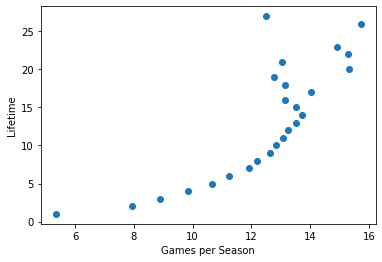

In [42]:
#checking a supposed nonlinear effect between lifetime and body stress (number of games played and rushing)

#df_plot=df[df['position']=='LB'].groupby('lifetime')['games'].mean().reset_index()
df_plot=df.groupby('lifetime')['games'].mean().reset_index()
plt.scatter(df_plot['games'], df_plot['lifetime'])
plt.xlabel('Games per Season')
plt.ylabel('Lifetime')

In [7]:
#creating the first cox regression, with positions only as covariates

df_filter=df.groupby('position').size().reset_index()
df_filter=df_filter[df_filter[0]>50]
df_filter=df_filter.drop(0, axis=1)

group=[]
for row in range(len(df_filter.index)):
    if df_filter.iloc[row, 0] in ['RB', 'HB', 'FB']:
        group.append('runner')
    elif df_filter.iloc[row, 0]  in ['QB']:
        group.append('qb')
    elif df_filter.iloc[row, 0]  in ['K', 'P']:
        group.append('special')
    elif df_filter.iloc[row, 0]  in ['WR', 'TE']:
        group.append('receiver')
    elif df_filter.iloc[row, 0]  in ['C', 'G', 'C-G', 'G-T', 'OT', 'T-G', 'G-C', 'OG', 'T']:
        group.append('o-line')
    elif df_filter.iloc[row, 0]  in ['DE', 'DT', 'DE-DT', 'DT-DE', 'NT', 'E', 'DE-LB']:
        group.append('d-line')
    elif df_filter.iloc[row, 0]  in ['LB', 'OLB', 'ILB', 'LB-DE']:
        group.append('lb')
    elif df_filter.iloc[row, 0]  in ['CB', 'DB', 'S', 'DB-HB', 'FS', 'SS']:
        group.append('secondary')

df_filter['group']=group

df_cox=df[['position', 'lifetime', 'retired']]
#df_cox=df[['position', 'lifetime']]
df_cox=df_cox.merge(df_filter, on='position', how='inner')

df_cox=df_cox.drop('position', axis=1)
df_cox = pd.get_dummies(df_cox, columns=['group'])

cph = lifelines.CoxPHFitter(penalizer=0.0001)
cph.fit(df_cox, duration_col='lifetime', event_col='retired')

cph.print_summary()

<lifelines.CoxPHFitter: fitted with 17736 total observations, 1810 right-censored observations>
             duration col = 'lifetime'
                event col = 'retired'
                penalizer = 0.0001
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 17736
number of events observed = 15926
   partial log-likelihood = -139562.48
         time fit was run = 2021-09-29 15:30:41 UTC

---
                  coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                               
group_d-line     -0.06       0.94       0.81            -1.66             1.53                 0.19                 4.62
group_lb          0.02       1.02       0.81            -1.57             1.62                 0.21                 5.05
group_o-line     -0.16       0.85       0.81            -1.76             1.43                 0.17                 4.19
group_qb         -0.47       0.63       0.81            -2.06             1.13                 0.13                 3.09
group_receiver    0.13       1.14       0.81            -1.46             1.73                 0.23                 5.62
group_runner      0.26       1.30       0.81            -1.33             1.86                 0.26                 6.42
group_secondary   0.06       1.06       0.81            -1.54             1.65                 0.22                 5.22
group_special    -0.46       0.63       0.81            -2.05             1.14                 0.13                 3.12

                    z    p   -log2(p)
covariate                            
group_d-line    -0.08 0.94       0.09
group_lb         0.03 0.98       0.04
group_o-line    -0.20 0.84       0.25
group_qb        -0.57 0.57       0.82
group_receiver   0.16 0.87       0.20
group_runner     0.33 0.74       0.43
group_secondary  0.07 0.94       0.09
group_special   -0.56 0.57       0.80
---
Concordance = 0.54
Partial AIC = 279140.96
log-likelihood ratio test = 539.01 on 8 df
-log2(p) of ll-ratio test = 367.16

In [169]:
df_filter=df.groupby('position').size().reset_index()
df_filter=df_filter[df_filter[0]>50]
pd.options.display.max_rows = 10
df_filter.sort_values(0, ascending=False)
df_filter.head(5)



,position,0
6,C,389
11,C-G,110
20,CB,266
21,DB,2907
28,DB-HB,72


<AxesSubplot:xlabel='min_year'>

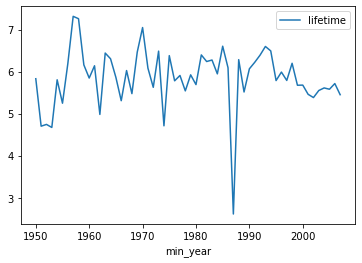

In [250]:
#checking era impact in QB lifetime

df_era=df[(df['min_year']<=2007) & (df['position']<='QB')][['lifetime', 'min_year']].groupby('min_year').mean()
df_era.plot()

<ipython-input-22-31ed251f7485>:20: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


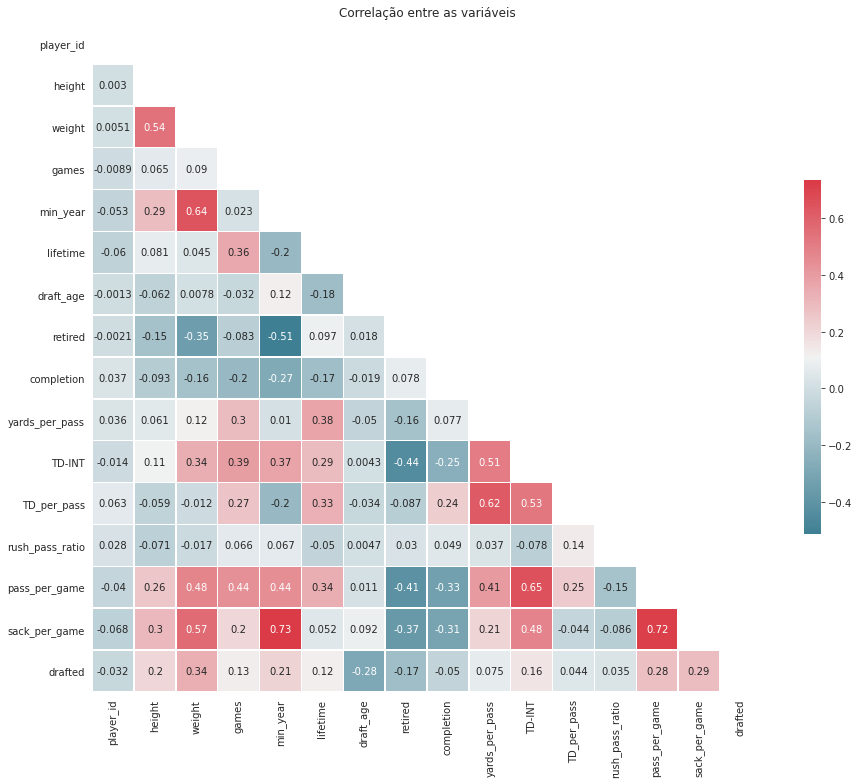

In [22]:
#correlation between variables
import seaborn as sns

df_cox=df[df['position']=='QB'][['player_id','height', 'weight', 'draft_round','passing_attempts', 'passing_completions', 'passing_yards','passing_touchdowns', 'passing_interceptions', 'passing_sacks','rushing_attempts', 'rushing_yards','games', 'min_year', 'lifetime', 'draft_age','retired']]
df_cox['completion']=(df_cox['passing_completions']/df_cox['passing_attempts'].replace(to_replace=0, value=1)).fillna(0)
df_cox['yards_per_pass']=(df_cox['passing_yards']/df_cox['passing_completions']).fillna(0)
df_cox['TD-INT']=(df_cox['passing_touchdowns']/df_cox['passing_interceptions'].replace(to_replace=0, value=1))
df_cox['TD_per_pass']=(df_cox['passing_touchdowns']/df_cox['passing_completions']).fillna(0)
df_cox['rush_pass_ratio']=(df_cox['rushing_attempts']/df_cox['passing_attempts'].replace(to_replace=0, value=1)).fillna(0)
df_cox['pass_per_game']=(df_cox['passing_attempts']/df_cox['games']).fillna(0)
df_cox['sack_per_game']=(df_cox['passing_sacks']/df_cox['games']).fillna(0)
#df_cox['draft_round']=np.where(df_cox['draft_round']==100, 'undrafted', np.where(df_cox['draft_round']>7,'>7', df_cox['draft_round']))
#df_cox['draft_round']=np.where(df_cox['draft_round']>7,'>7', df_cox['draft_round'])
df_cox['drafted']=np.where(df_cox['draft_round']>7,0, 1)
df_cox=df_cox.drop(['draft_round', 'passing_attempts', 'passing_sacks', 'passing_completions', 'passing_yards','rushing_yards', 'passing_interceptions', 'passing_touchdowns', 'rushing_attempts'], axis=1)
df_cox=df_cox[(df_cox['games']>5) & (df_cox['lifetime']<27)]

corr = df_cox.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap = True)

with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(15, 13))
    ax = sns.heatmap(corr, mask=mask, annot = True, cmap = cmap, square=True,
                     linewidths = .5, cbar_kws = {"shrink": .5})
    plt.title('Correlação entre as variáveis')

<AxesSubplot:>

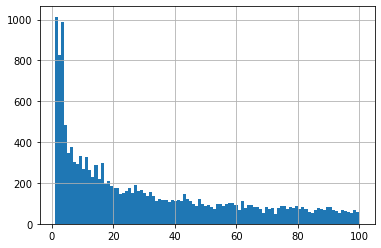

In [273]:
df_played[df_played['games']<=100]['games'].hist(bins=100)

In [23]:
#analyzing the quarterbacks regression
#df_cox=df[df['position']=='QB'][['height', 'weight', 'draft_round','passing_attempts', 'passing_completions', 'passing_yards','passing_touchdowns', 'passing_interceptions', 'passing_sacks','rushing_attempts', 'rushing_yards', 'rushing_touchdowns','games', 'min_year', 'lifetime', 'draft_age','retired']]


cph = lifelines.CoxPHFitter()
cph.fit(df_cox.drop('player_id', axis=1), duration_col='lifetime', event_col='retired')

cph.print_summary()




<lifelines.CoxPHFitter: fitted with 449 total observations, 53 right-censored observations>
             duration col = 'lifetime'
                event col = 'retired'
      baseline estimation = breslow
   number of observations = 449
number of events observed = 396
   partial log-likelihood = -1895.67
         time fit was run = 2021-09-29 15:37:06 UTC

---
                  coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                               
height            0.00       1.00       0.02            -0.04             0.04                 0.96                 1.05
weight           -0.01       0.99       0.01            -0.02             0.00                 0.98                 1.00
games            -0.02       0.98       0.02            -0.07             0.02                 0.93                 1.02
min_year          0.01       1.01       0.01            -0.00             0.02                 1.00                 1.02
draft_age         0.15       1.16       0.04             0.07             0.23                 1.07                 1.26
completion        0.40       1.49       0.12             0.16             0.63                 1.18                 1.89
yards_per_pass   -0.41       0.67       0.07            -0.55            -0.26                 0.58                 0.77
TD-INT           -0.79       0.46       0.27            -1.32            -0.25                 0.27                 0.78
TD_per_pass       0.38       1.46       7.71           -14.73            15.50                 0.00             5.38e+06
rush_pass_ratio   0.02       1.02       0.04            -0.05             0.10                 0.95                 1.10
pass_per_game    -0.07       0.94       0.02            -0.10            -0.03                 0.90                 0.97
sack_per_game     0.25       1.28       0.12             0.02             0.48                 1.02                 1.61
drafted          -0.09       0.92       0.12            -0.33             0.15                 0.72                 1.17

                    z      p   -log2(p)
covariate                              
height           0.15   0.88       0.18
weight          -1.70   0.09       3.49
games           -1.04   0.30       1.73
min_year         1.66   0.10       3.38
draft_age        3.50 <0.005      11.05
completion       3.31 <0.005      10.08
yards_per_pass  -5.51 <0.005      24.70
TD-INT          -2.88 <0.005       7.97
TD_per_pass      0.05   0.96       0.06
rush_pass_ratio  0.58   0.56       0.83
pass_per_game   -3.61 <0.005      11.68
sack_per_game    2.14   0.03       4.96
drafted         -0.71   0.48       1.07
---
Concordance = 0.76
Partial AIC = 3817.35
log-likelihood ratio test = 241.23 on 13 df
-log2(p) of ll-ratio test = 144.08

0.9771876390399643

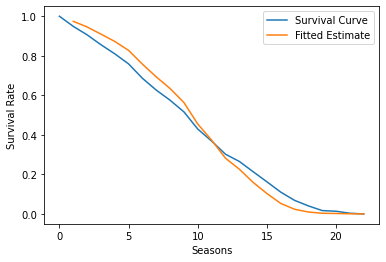

In [24]:
from sklearn.metrics import r2_score

km=lifelines.fitters.kaplan_meier_fitter.KaplanMeierFitter()
km.fit(df_cox['lifetime'], df_cox['retired'])
plt.plot(km.survival_function_, label='Survival Curve')
plt.plot(cph.baseline_survival_, label='Fitted Estimate')
plt.xlabel('Seasons')
plt.ylabel('Survival Rate')
plt.legend()
r2_score(km.survival_function_[1:20].iloc[:,0], cph.baseline_survival_[0:20].iloc[:,0])


ICI =  0.06515678396802922
E50 =  0.0764779903493249


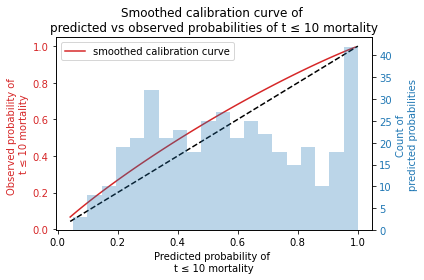

In [305]:
#calibration curves
from lifelines.calibration import survival_probability_calibration
survival_probability_calibration(cph, df_cox[df_cox['retired']==1], t0=10)
a=1

'TD-INT'

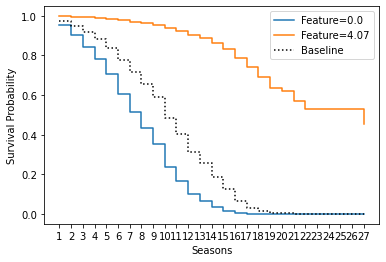

In [306]:
#plotting the actual survival curve with some covariate together

variavel='TD-INT'

minimum=df_cox[variavel].min()
mean=df_cox[variavel].mean()
maximum=df_cox[variavel].max()
ax=cph.plot_partial_effects_on_outcome(variavel, values=[minimum, maximum])
ax.legend(['Feature='+str(round(minimum,2)), 'Feature='+str(round(maximum,2)), 'Baseline'])#, loc='lower right')
ax.set_xlabel('Seasons')
ax.set_ylabel('Survival Probability')
ax.set_xticks(range(1,28))
variavel

In [33]:
#predicting some notable quarterbacks

brady=df_profiles[df_profiles['name']=='Tom Brady ']['player_id'].values[0]
peyton=df_profiles[df_profiles['name']=='Peyton Manning']['player_id'].values[0]
favre=df_profiles[df_profiles['name']=='Brett Favre ']['player_id'].values[0]
luck=df_profiles[df_profiles['name']=='Andrew Luck ']['player_id'].values[0]
vick=df_profiles[df_profiles['name']=='Michael Vick']['player_id'].values[0]
rivers=df_profiles[df_profiles['name']=='Philip Rivers']['player_id'].values[0]
romo=df_profiles[df_profiles['name']=='Tony Romo ']['player_id'].values[0]
brees=df_profiles[df_profiles['name']=='Drew Brees']['player_id'].values[0]
leaf=df_profiles[df_profiles['name']=='Ryan Leaf']['player_id'].values[0]
sanchez=df_profiles[df_profiles['name']=='Mark Sanchez']['player_id'].values[0]

cph.predict_expectation(df_cox[df_cox['player_id']==brady].drop('player_id', axis=1))
#cph.predict_median(df_cox[df_cox['player_id']==sanchez].drop('player_id', axis=1))
#cph.predict_survival_function(df_cox[df_cox['player_id']==sanchez].drop('player_id', axis=1))


7516    18.665636
dtype: float64

In [30]:
df_cox[df_cox['player_id']==brady]

,player_id,height,weight,games,min_year,lifetime,draft_age,retired,completion,yards_per_pass,TD-INT,TD_per_pass,rush_pass_ratio,pass_per_game,sack_per_game,drafted
7516,2240,76,225.0,15.666667,2000,18.0,23.0,0,1.567044,7.436979,2.930108,0.054735,0.100881,22.531915,1.780142,1


<AxesSubplot:>

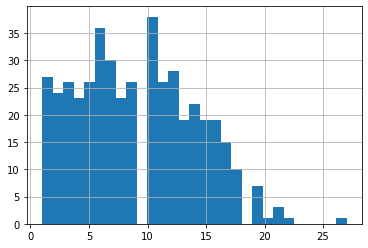

In [21]:
df_cox[df_cox['lifetime']==27]
df_cox[df_cox['player_id']==1853]
#df_cox.groupby('min_year')['lifetime'].max().plot()
df_cox['lifetime'].hist(bins=29)